<a href="https://colab.research.google.com/github/brandonb1121/personalprojects/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q gwpy

In [ ]:
import pandas as pd
import numpy as np
import requests
import re
from osgeo import ogr
from google.colab import drive
import matplotlib as mpl
import matplotlib.pyplot as plt

drive.mount('/content/drive')
path1 = '/content/drive/My Drive/df_snowfall.csv'
path2 = '/content/drive/My Drive/df_stations.csv'
path3 = '/content/drive/My Drive/df_ca_resorts.csv'

df_snowfall = df = pd.read_csv(path1)
df_stations = df = pd.read_csv(path2)
df_ca_resorts = df = pd.read_csv(path3)
df_snowfall.drop("Unnamed: 0", axis=1, inplace=True)
df_stations.drop("Unnamed: 0", axis=1, inplace=True)
df_ca_resorts.drop("Unnamed: 0", axis=1, inplace=True)
#Have to make minor cleaning adjustments for a column since it was acting up in the other CoLab
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df_snowfall['1_wk_ago']=df_snowfall['1_wk_ago'].apply(lambda cw : remove_tags(cw))
df_snowfall['1_wk_ago'] = pd.to_numeric(df_snowfall['1_wk_ago'].str.replace(r'\D', ''))/10
df_merged = df_snowfall.merge(df_stations, on=["station_id"])
df_merged["year"] = pd.to_numeric(df_merged["date"].str[:4])
df_merged["month"] = pd.to_numeric(df_merged["date"].str[5:7])
df_merged["day"] = pd.to_numeric(df_merged["date"].str[8:])
df_merged["date"] = pd.to_datetime(df_merged["date"], format="%Y-%m-%d")

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: The default value of regex will change from True to False in a future version.


6    137.674787
5    138.133156
7    142.104500
4    143.201224
3    144.349266
dtype: float64

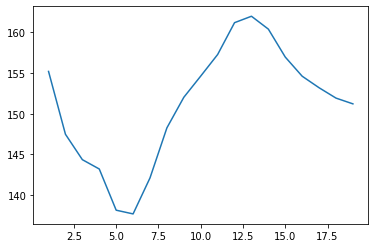

In [ ]:
# The first ML model will be a K-nearnest neighbors regression to determine snowfall for each ski resort in California
# The first step involves finding the optimal number of numbers for the model to be the most accurate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

X_train = df_merged[["longitude", "latitude", "elevation", "month", "year"]]
y_train = df_merged["daily snowfall"]

def get_cv_error(k):
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k)
  ) 
  cv_errs = -cross_val_score(pipeline, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  return cv_errs.mean()
    
ks = pd.Series(range(1, 20))
ks.index = range(1, 20)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values().head()

In [ ]:
# With the optimal number of neighbors for the KNN model, we can now determine which combination of variables will produce the lowest MSE
def get_cv_error(features):
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=6)
  )
  cv_errs = -cross_val_score(pipeline, X=df_merged[features], 
                             y=df_merged["daily snowfall"],
                             scoring="neg_mean_squared_error", cv=10)
  return cv_errs.mean()

errs = pd.Series()
for features in [["latitude", "longitude"],
                 ["latitude", "longitude", "elevation"],
                 ["latitude", "longitude", "elevation", "year"],
                 ["latitude", "longitude", "elevation", "month"],
                 ["latitude", "longitude", "year", "month"],
                 ["latitude", "longitude", "elevation", "month", "year"]]:
  errs[str(features)] = get_cv_error(features)

errs.sort_values()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


['latitude', 'longitude', 'elevation', 'month', 'year']    137.674787
['latitude', 'longitude', 'year', 'month']                 163.968918
['latitude', 'longitude', 'elevation', 'year']             232.353783
['latitude', 'longitude', 'elevation', 'month']            265.392025
['latitude', 'longitude', 'elevation']                     317.833758
['latitude', 'longitude']                                  373.761228
dtype: float64

In [ ]:
# With 6 neighbors as our most optimal number and using the best 5 variables, we are able to now create the best possible model.
X_train = df_merged[["longitude", "latitude", "elevation", "month", "year"]]
y_train = df_merged["daily snowfall"]
pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=6)
  ) 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=6))])

In [ ]:
# We can now create a testing model with all the resorts and manually insering the month and year for each
# This is so we can predict the upcoming season's snowfall, even if we don't know the actual data
%%capture
x_test = df_ca_resorts[["resort_name", "latitude", "longitude", "elevation"]]
x_test["year"], x_test["month"] = 2022, 12
x_test["pred snowfall"] = pipeline.predict(x_test[["longitude", "latitude", "elevation", "month", "year"]])
dates = [(2023,1), (2023,2), (2023,3), (2023,4), (2023,5)]
for date in dates:
  x_test_ = df_ca_resorts[["resort_name", "latitude", "longitude", "elevation"]]
  x_test_["year"], x_test_["month"] = date[0], date[1]
  x_test_["pred snowfall"] = pipeline.predict(x_test_[["longitude", "latitude", "elevation", "month", "year"]])
  x_test = pd.concat([x_test, x_test_])

x_test.reset_index(inplace=True)
x_test.drop(columns=["index"], inplace=True)

x_test["year"] = x_test["year"].map(str)
x_test["month"] = x_test["month"].map(str)
times = []
for i in range(len(x_test)):
  times.append(x_test.at[i, "year"] + x_test.at[i, "month"])

x_test["date"] = times
x_test["date"] = pd.to_datetime(x_test["date"], format="%Y%m")

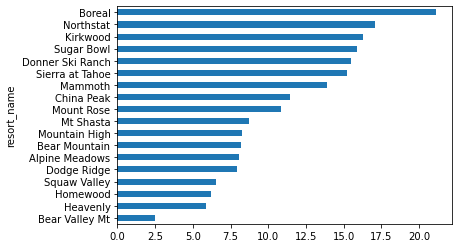

In [ ]:
# What is the predicted average monthly snowfall for the 2022-2023 season at each resort?
x_test.groupby("resort_name")["pred snowfall"].mean().sort_values().plot.barh()

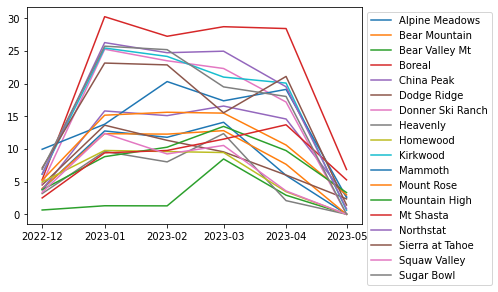

In [ ]:
# What will the monthly snowfall for each resort look like this upcoming season?
df_pred_resorts = x_test[["resort_name", "pred snowfall", "date"]]
df_pred_resorts.set_index(df_pred_resorts["date"], inplace=True)
df_pred_resorts.drop(columns=["date"])
for resort in df_pred_resorts["resort_name"].unique():
  x = df_pred_resorts[df_pred_resorts["resort_name"] == resort]
  x = x["pred snowfall"]
  plt.plot(x, label=resort)

plt.legend(title="Resort")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
# Now, we are able to measure how accurate this model actually was
# Because there's no actual snowfall data for the results, we are measuring the success of the model using the location of the stations instead
from sklearn.model_selection import cross_val_score
# MSE & RMSE of the model
x_train = df_merged[["longitude", "latitude", "elevation", "month", "year"]]
y_train = df_merged["daily snowfall"]
scores = cross_val_score(pipeline, 
                         X=x_train,
                         y=y_train,
                         scoring="neg_mean_squared_error",
                         cv=10)
print("MSE:", (-scores).mean(),"\nRMSE:", np.sqrt(-scores).mean())

MSE: 137.67478678755384 
RMSE: 11.646300911108252


In [ ]:
# r2 value of the model
scores = cross_val_score(pipeline, 
                         X=x_train,
                         y=y_train,
                         scoring="r2",
                         cv=10)
print("r2:",scores.mean())

r2: 0.4092551597362343
